<table>
  <tr>
      <td><div style="white-space: pre-wrap;" align="left"><font size="30" >Tutorial B2&#10;EKF </font></div></td>
     <td><img src="https://github.com/Tobias-Fischer/RVSS2022/blob/main/Spatial_Awareness/Tutorial_B2_Robot_Localisation/image/RVSS-logo.png?raw=1" width="400"></td>
  </tr>
</table>

# Load data and run only motion model prediction

In [1]:
#Import all the nessesary modules
#import sys
#!{sys.executable} -m pip install import_ipynb
import os

!git clone https://github.com/Tobias-Fischer/RVSS2022.git
os.chdir('RVSS2022/Spatial_Awareness/Tutorial_B2_Robot_Localisation')

#%matplotlib notebook
#import matplotlib.pyplot as plt
#import import_ipynb
import math
import numpy as np
import pickle
#widgest allows interactive elements 
#from ipywidgets import *
#Here we import from a python file support functions to visualize our robot
from importlib import import_module
#Visualizer
#from Render import *
#Here we import Robot class definition form the other notebook
from EKF_Robot import *
#Here we import a class that defines out measurments
from Measurements import *

Cloning into 'RVSS2022'...
remote: Enumerating objects: 479, done.
remote: Counting objects: 100% (479/479), done.
remote: Compressing objects: 100% (385/385), done.
remote: Total 479 (delta 241), reused 287 (delta 86), pack-reused 0
Receiving objects: 100% (479/479), 30.91 MiB | 12.99 MiB/s, done.
Resolving deltas: 100% (241/241), done.
Checking out files: 100% (133/133), done.


In [36]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import os
from PIL import Image

def arrow(x,y,theta,size):
  c=np.cos(theta)
  s=np.sin(theta)
  return([x,
         x+c*size,
         x+(0.75*c-0.15*s)*size,
         None,
         x+c*size,
         x+(0.75*c+0.15*s)*size],
         [y,
          y+s*size,
          y+(0.75*s+0.15*c)*size,
          None,
          y+s*size,
          y+(0.75*s-0.15*c)*size])

def robot(state,xcol,ycol,rx,ry,ra,rc):
  arrowsize=0.1
  for t in range(state.shape[0]):
    x=state[t,0]
    y=state[t,1]
    theta=state[t,2]
    arrx,arry = arrow(x, y, theta, arrowsize)
    rx+=arrx
    ry+=arry
    ra+=[t]*6
    rc+=[xcol]*6
    arrx,arry = arrow(x, y, theta+np.pi/2, arrowsize)
    rx+=arrx
    ry+=arry
    ra+=[t]*6
    rc+=[ycol]*6

def ellipse(pos,covariance,numpts,scale=10):
  a = covariance[0,0]
  b = covariance[0,1]
  c = covariance[1,1]
  ap = 1/np.sqrt(a-b*b/c)
  bp = -b*ap/c
  cp = 1/np.sqrt(c)
  invsqrt=np.array([[a,0],[b,c]])
  xs,ys=[],[]
  for i in range(numpts+1):
    theta = i*2*np.pi/numpts
    circlepos = np.array([scale*np.cos(theta),scale*np.sin(theta)])
    coord = circlepos+pos #np.matmul(invsqrt,circlepos)+pos
    xs.append(coord[0])
    ys.append(coord[1])
  return (xs,ys)
  
def meas(state,m,mcol,rx,ry,ra,rc):
  for t in range(len(m)):
    rpos = state[t,0:2]
    rtheta = state[t,2]
    c=np.cos(rtheta)
    s=np.sin(rtheta)
    rrot = np.array([[c,-s],[s,c]])

    mms=m[t]
    numpts=10
    for mm in mms:
      mpos = mm.position
      mcov = mm.covariance

      mwpos = rpos+np.matmul(rrot,mpos)
      mwcov = np.matmul(np.matmul(rrot,mcov),rrot.transpose())

      #xell,yell = ellipse(mwpos,mwcov,numpts)
      #rx+=xell
      #ry+=yell
      #ra+=[t]*(numpts+1)
      #rc+=[mcol]*(numpts+1)
      rx+=[rpos[0],rpos[0]+mpos[0,0]]
      ry+=[rpos[1],rpos[1]+mpos[1,0]]
      ra+=[t,t]
      rc+=[mcol,mcol]

def Render(state=None, gtstate=None, measurements=None):
  x,y,a,c=[],[],[],[]

  if(state is not None):
    robot(state,'r','g',x,y,a,c)
    
  if(gtstate is not None):
    robot(gtstate,'dr','dg',x,y,a,c)

  if(measurements is not None):
    meas(state, measurements,'b',x,y,a,c)

  ell1=len(measurements)*24
  print(x[ell1],y[ell1],a[ell1],c[ell1])
  print(x[ell1+1],y[ell1+1],a[ell1+1],c[ell1+1])

  colmap={'r':'#FF0000','g':'#00FF00','dr':'#800000','dg':'#008000','b':'#8080ff'}
  fig = px.line(x=x,y=y,animation_frame=a, color=c, color_discrete_map=colmap)

  marker_files = [filename for filename in os.listdir('./image') if filename.startswith("M")]
  marker_world_width = 0.3
  for i,filename in enumerate(marker_files):
    fprts = filename.split('_')
    xpos = float(fprts[1])
    ypos = float(fprts[2])
    im = Image.open('image/' + filename)
    imsize = 0.3
    # Add images
    fig.add_layout_image(
        dict(
            source = im,
            xref="x",
            yref="y",
            x=xpos-imsize/2,
            y=ypos+imsize/2,
            sizex=imsize,
            sizey=imsize,
            sizing="contain",
            opacity=1.0,
            layer="below")
    )

  fig.update_xaxes(showgrid=False, range = [-4,-2])
  fig.update_yaxes(showgrid=False, range = [-3.5,-1.5])
  fig.update_layout(template="plotly_white", showlegend=False)
  fig.update_layout(width = 500, height=530) #makes it look square on my screen
  fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 100
  fig.show()


In [28]:
A=np.array([[1,0],[0,1]])
b=np.array([1,2])
c=np.matmul(A,b)
print(c)
print(A[0,0:2])

[1 2]
[1 0]


## Download groud truth and measurement data

[[0.1 0. ]
 [0.  0.1]]
-2.8 -2.8 0 b
-2.6182487870176 -1.7343609942989022 0 b



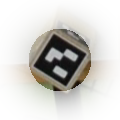
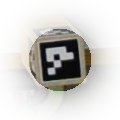
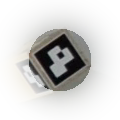
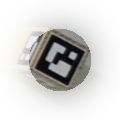
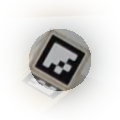
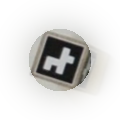
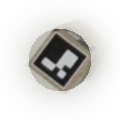
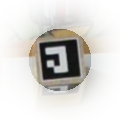
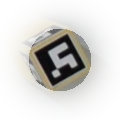
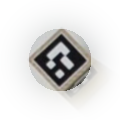

In [37]:
#Here we load our data including the true state 
with open('data/data_ekf.dat', "rb") as f:
    data = pickle.load(f)
    
gt_state = data['state']
control = data['control']
measurements = data['measurement']

print(measurements[0][0].covariance)

#Create a robot and place it at the true starting position and orientation 
bot = EKF_Robot(0.14, 0.01)
#Place the robot at -2.8,-2.8 which is bottom middle of our arena
bot.state = gt_state[0,:].copy().reshape(-1,1)

#Apply our control to the robot and visualize
#Our timestamp is always 0.2
dt = 0.2
#Here we will save our state variable 
state = np.zeros((control.shape[0],3))


for c in range(control.shape[0]):
    state[c,:] = bot.state[:,0]
    drive_signal = DriveMeasurement(control[c,0],control[c,1],dt)
    bot.drive(drive_signal)

#Create a visualizer and visualize our atate
Render(state=state, gtstate=gt_state, measurements=measurements)
#rend = Rendered.Instance()
#rend.initialize(state,measurements,gt_state = gt_state)

# Now run EKF

In [ ]:
#%matplotlib notebook
#import matplotlib.pyplot as plt
#import import_ipynb
#import math
#import numpy as np
#import pickle
#widgest allows interactive elements 
#from ipywidgets import *
#Here we import from a python file support functions to visualize our robot
from importlib import import_module
#Visualizer
from Render import *
#Here we import Robot class definition form the other notebook
from EKF_Robot import *
#Here we import a class that defines out measurments
from Measurements import *
import EKF

#Here we load our data including the true state 
with open('data/data_ekf.dat', "rb") as f:
    data = pickle.load(f)
    
gt_state = data['state']
control = data['control']
measurements = data['measurement']


#Here are our true marker positions
markers = data['markers']
#Now lets see how well slam does
#Create a robot and place it at the true starting position and orientation 
bot = EKF_Robot(0.15, 0.01)
#Place the robot at -2.8,-2.8 which is bottom middle of our arena
bot.state = gt_state[0,:].copy().reshape(-1,1)

ekf = EKF.RobotEKF(bot,markers)
#Initial incertainty of our robot
ekf.P = np.eye(3)*100
#Uncertainty in our left and right wheel motors
sigma_drive = np.array([10,10])
#Uncertainty in measurement
sigma_measure = np.eye(2)*100

#Apply our control to the robot and visualize
#Our timestamp is always 0.2
dt = 0.2
#Here we will save our state variable 
state = np.zeros((control.shape[0],3))
#Here we save the robot covariances
robot_cov = np.zeros(((control.shape[0],3,3)))

for c in range(control.shape[0]):
    #Set the measurement covariances
    for mes in measurements[c]:
        mes.covariance = sigma_measure 
    drive_signal = DriveMeasurement(control[c,0],control[c,1],dt,sigma_drive[0],sigma_drive[1])
    ekf.predict(drive_signal)
    ekf.update(measurements[c])
    state[c,:] = bot.state[:,0]
    #drive_signal = DriveMeasurement(control[c,0],control[c,1],dt,sigma_drive[0],sigma_drive[1])
    # Drive and predict
    robot_cov[c,:,:] = ekf.P[0:3,0:3]
    
#Create a visualizer and visualize our state
rend = Rendered.Instance()
rend.initialize(state,measurements,gt_state = gt_state,robot_cov=robot_cov)



In [ ]:
state[296,:]